In [ ]:
#importing the needed librabries for this work
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import  image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_image
import os,warnings, random,shutil
warnings.filterwarnings('ignore')
import codecs
codecs.register_error("strict",codecs.ignore_errors)
from tensorflow.keras.applications import ResNet50,EfficientNetB3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
#mounting my google drive inside my workspace
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


importing packages needed for image classifcation

This project aims to leverage deep learning for automatic garbage classification, sorting waste into ten distinct categories: **Metal, Glass, Biological Waste, Paper, Battery Waste, General Trash, Cardboard, Shoes, Clothes, and Plastic**. The objective is to develop a reliable image classification model capable of identifying waste items based on their visual characteristics. This system can enhance waste management efficiency and encourage more effective recycling practices.

1. Importing Required Libraries  
2. Dataset Loading  
3. Image Visualization  
4. Preprocessing Images  
5. Model Development  
   - **EfficientNetB3**  
   - **5.1 EfficientNetB3: Compilation & Training**  
6. ResNet50 Model  
   - **6.1 ResNet50: Compilation & Training**  
7. Convolutional Neural Network (CNN)  
   - **7.1 CNN: Compilation & Training**  
8. Model Performance Comparison (Accuracy & Loss)  
9. Making Predictions  
10. Predicting the First Class  
11. Conclusion & Acknowledgment

In [4]:
#loading of the dataset by specifiying the path on the drive
data_path= data_path = "/content/drive/MyDrive/garbage-dataset"
classes_names =os.listdir(data_path)
classes_names

['plastic',
 'glass',
 'shoes',
 'clothes',
 'biological',
 'trash',
 'battery',
 'cardboard',
 'metal',
 'paper']

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os  # Import the os module for interacting with the file system

# Define the base output directory where data folders will be created
out_dir = '/colab/working/'

# Define the paths for training, validation, and testing directories
train_dir = os.path.join(out_dir, 'train')
valid_dir = os.path.join(out_dir, 'valid')
test_dir = os.path.join(out_dir, 'test')

# Create each directory if it does not already exist
for folder in [train_dir, valid_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)
    # `exist_ok=True` ensures no error is raised if the folder already exists


In [ ]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split

# Define dataset split ratios
train_size = 0.7
validation_size = 0.15
test_ratio = 0.15

# Loop through each class folder
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)

    # Skip if not a directory
    if not os.path.isdir(class_path):
        continue

    # List image files
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]

    # Skip if not enough images to split
    if len(image_files) < 3:
        print(f"Skipping class '{class_name}' due to insufficient images ({len(image_files)}).")
        continue

    # Shuffle
    random.shuffle(image_files)

    # Split into train and temp (valid + test)
    train_images, temp_images = train_test_split(
        image_files,
        test_size=(1 - train_size),
        random_state=42
    )

    # Only split temp if it has more than 1 image
    if len(temp_images) > 1:
        valid_images, test_images = train_test_split(
            temp_images,
            test_size=(test_ratio / (test_ratio + validation_size)),
            random_state=42
        )
    else:
        # If only 1 image in temp, assign to validation and leave test empty
        valid_images, test_images = temp_images, []

    # Create destination folders
    for folder in [train_dir, valid_dir, test_dir]:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

    # Copy images to respective folders
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
    for image in valid_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(valid_dir, class_name, image))
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))


IMAGE VISUALZATION IN A RANDOM STATE

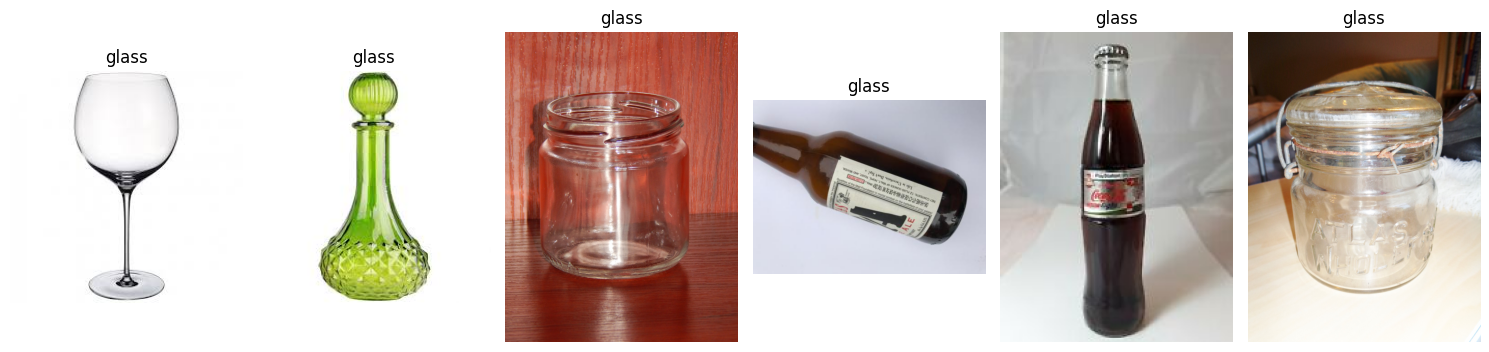

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


# Get list of classes (folders in dataset)
classes = [cls for cls in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, cls))]

# Set number of images to display
num_images = 6

# Randomly pick a class
selected_class = random.choice(classes)
class_path = os.path.join(data_path, selected_class)

# Get list of images in the selected class
image_files = [image for image in os.listdir(class_path) if image.endswith(('.jpg', '.png', '.jpeg'))]

# Randomly select images
selected_images = random.sample(image_files, min(num_images, len(image_files)))

# Plot the images
fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))

for ax, image_name in zip(axes, selected_images):
    image_paths = os.path.join(class_path, image_name)
    image = Image.open(image_paths)
    ax.imshow(image)
    ax.set_title(selected_class)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [42]:
# Create an image data generator for the training set
# We're using a ResNet-specific preprocessing function (scales pixels appropriately)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Prepares images in a way that matches ResNet expectations
)

# Create another image data generator for validation and test sets
# No augmentation is applied here; only preprocessing
valid_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load and prepare the training dataset from folders
train_generator = train_datagen.flow_from_directory(
    train_dir,                # Path to training data folder
    target_size=(224, 224),   # Resize all images to 224x224 (ResNet input size)
    batch_size=100,           # Number of images per batch
    class_mode='categorical'  # Because it's multi-class classification (10 classes), we use one-hot encoded labels
)

# Load and prepare the validation dataset
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,                # Path to validation data folder
    target_size=(224, 224),   # Resize to match training input size
    batch_size=100,           # Number of images per batch
    class_mode='categorical'  # One-hot encoded labels
)

# Load and prepare the test dataset
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,                 # Path to test data folder
    target_size=(224, 224),   # Resize to match input size
    batch_size=1,             # One image at a time (often used for precise evaluation or prediction)
    class_mode="categorical",          # No labels since we're only predicting
    shuffle=False,            # Keep order consistent for evaluation (important when matching filenames to predictions)
    seed=123                  # Set a seed for reproducibility
)


Found 13843 images belonging to 10 classes.
Found 2970 images belonging to 10 classes.
Found 2973 images belonging to 10 classes.


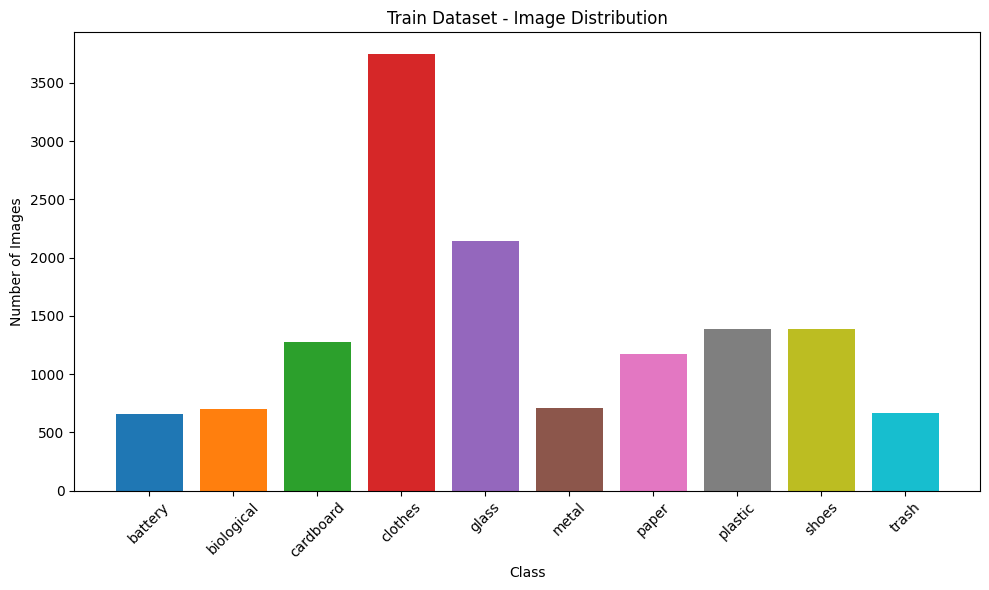

In [10]:
import os
import matplotlib.pyplot as plt

# Count images in each class
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort class names alphabetically for consistency
sorted_classes = sorted(class_counts.items())
class_names = [cls[0] for cls in sorted_classes]
class_values = [cls[1] for cls in sorted_classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_values, color=plt.cm.tab10.colors[:len(class_names)])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Train Dataset - Image Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


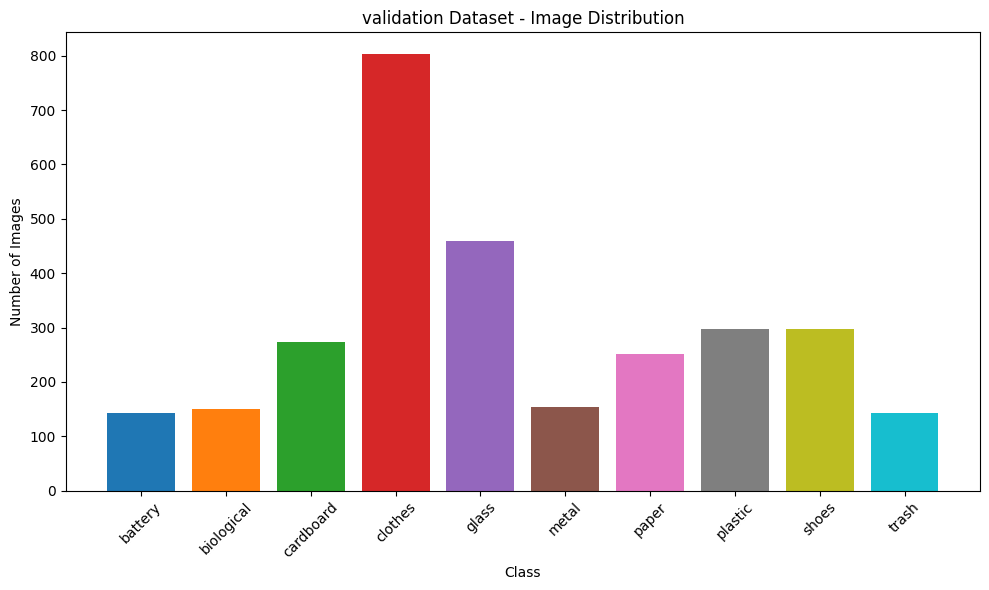

In [11]:
import os
import matplotlib.pyplot as plt

# Count images in each class
class_counts = {}
for class_name in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort class names alphabetically for consistency
sorted_classes = sorted(class_counts.items())
class_names = [cls[0] for cls in sorted_classes]
class_values = [cls[1] for cls in sorted_classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_values, color=plt.cm.tab10.colors[:len(class_names)])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("validation Dataset - Image Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


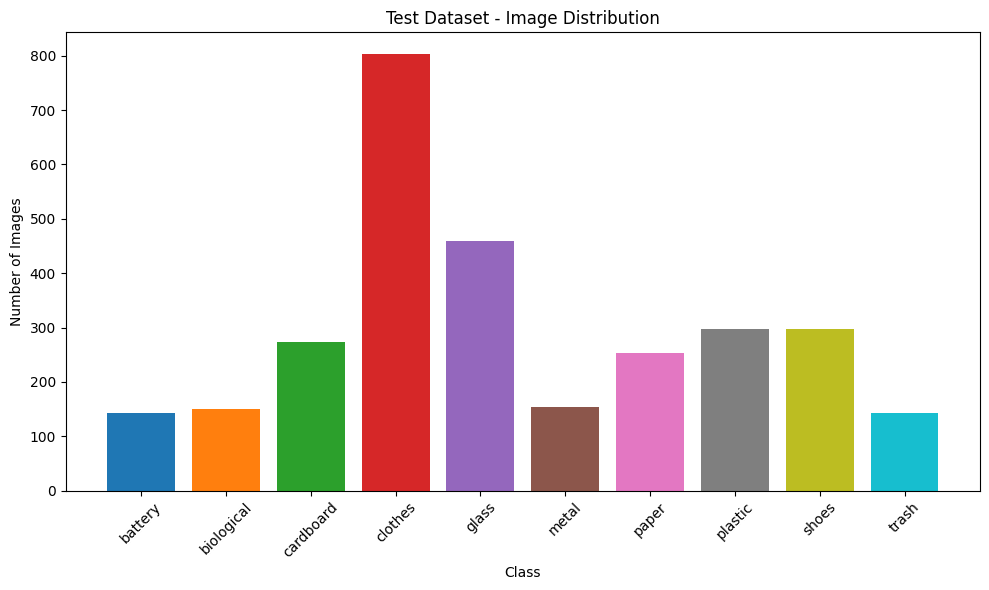

In [12]:
import os
import matplotlib.pyplot as plt

# Count images in each class
class_counts = {}
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort class names alphabetically for consistency
sorted_classes = sorted(class_counts.items())
class_names = [cls[0] for cls in sorted_classes]
class_values = [cls[1] for cls in sorted_classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_values, color=plt.cm.tab10.colors[:len(class_names)])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Test Dataset - Image Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
class_labels=train_generator.class_indices
print(class_labels)

{'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


In [14]:
# Load the EfficientNetB3 model as the base
# We're removing the top (fully connected) layers so we can add our own
# 'pooling=avg' means we'll apply global average pooling to the final convolutional output
# 'weights=imagenet' means we're using pre-trained weights from ImageNet
base_model = EfficientNetB3(include_top=False, pooling='avg', weights='imagenet')

# Freeze the entire base model so its weights don't get updated during training
# This allows us to retain the powerful features learned from ImageNet
base_model.trainable = False

# Add custom layers on top of the base model for our specific classification task
x = Dense(128, activation='relu')(base_model.output)  # First custom dense layer
x = Dense(64, activation='relu')(x)                   # Second custom dense layer
output_layer = Dense(10, activation='softmax')(x)     # Output layer for 10 classes using softmax

# Create the full model by connecting the base model's input to our custom output layer
model_1 = Model(inputs=base_model.input, outputs=output_layer)

# Print a summary of the entire model architecture
model_1.summary()



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,080 │ stem_conv_pad[0]… │
│                     │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 40)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        960 │ block1a_se_excit

 Total params: 10,989,177 (41.92 MB)

 Trainable params: 205,642 (803.29 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [15]:
#complie our model for training
#selected our optimizer to be rmsprop
#selected our loss to br categorical crossentropy for muti class classification
#selected our metrics based pon accuracy
model_1.compile(optimizer='Rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
#implemnting early stop callback to select the best epoch during the training by monitoring the validation loss
early_stop=EarlyStopping(monitor='val_loss',patience=10)
checkpoint=ModelCheckpoint(filepath='/colab/working/best.keras',monitor='val_loss',save_best_only=True,mode='auto')

In [17]:
# Train the model using the training and validation data generators
history_1 = model_1.fit(
    train_generator,                            # Training data generator
    steps_per_epoch=train_generator.samples // 100,  # Number of batches per epoch (total samples divided by batch size)
    validation_data=valid_generator,            # Validation data generator
    validation_steps=valid_generator.samples // 100,  # Number of validation batches per epoch
    epochs=10,                                  # Total number of epochs to train
    callbacks=[early_stop, checkpoint]          # List of callbacks: early stopping and model checkpointing
)


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 145s 747ms/step - accuracy: 0.5436 - loss: 1.9338 - val_accuracy: 0.7255 - val_loss: 0.8801
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.6900 - loss: 1.0258 - val_accuracy: 0.7207 - val_loss: 0.8874
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 587ms/step - accuracy: 0.7036 - loss: 1.3057 - val_accuracy: 0.7390 - val_loss: 0.8010
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8100 - loss: 1.0884 - val_accuracy: 0.7390 - val_loss: 0.7911
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 595ms/step - accuracy: 0.7402 - loss: 1.0631 - val_accuracy: 0.7510 - val_loss: 0.7588
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.7300 - loss: 2.5973 - val_accuracy: 0.7486 - val_loss: 0.7779
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 69s 497ms/step - accuracy: 0.7471 - loss: 0.9614 - val_accuracy: 0.7628 - val_loss: 0.7218
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.7500 - loss: 0.67

In [18]:
# saving the model
model_1.save("my_model.keras")  # creates a .keras file

# HDF5 format
model_1.save("my_model_1.h5")     # creates a .h5 file


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model_1.predict(test_generator, verbose=0)

# for multi class classification
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[101   3   3   7  14   3   2   0   8   1]
 [  4  90   2  19   9   8   2   0   6  10]
 [  7   5 213   9  11   2  16   5   2   4]
 [  2  19   1 714  15  10   6   2  17  17]
 [  8  12   4  24 357  11   3  21  10  10]
 [  2   7   5  10  12 106   1   0   7   4]
 [  3   4  18  14   7   6 191   2   7   1]
 [  0  12   8  23  32   7   2 197   4  13]
 [  7  18   0  39  23   5   0   4 198   3]
 [  2   7   2   3   9   5   2   2   2 108]]


In [20]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_true is the true labels and y_pred are the predicted probabilities
y_pred_prob = model_1.predict(test_generator, verbose=0)

# For multiclass classification, convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure y_true is in the correct format and the classes are correct
y_true = test_generator.classes

# Generate classification report
ClassificationReport = classification_report(y_true, y_pred, target_names=["Metal", "Glass", "Biological Waste", "Paper",
                                                                          "Battery Waste", "General Trash", "Cardboard", "Shoes",
                                                                          "Clothes", "Plastic"])

# Print the classification report
print('Classification Report:\n', ClassificationReport)


Classification Report:
                   precision    recall  f1-score   support

           Metal       0.74      0.71      0.73       142
           Glass       0.51      0.60      0.55       150
Biological Waste       0.83      0.78      0.80       274
           Paper       0.83      0.89      0.86       803
   Battery Waste       0.73      0.78      0.75       460
   General Trash       0.65      0.69      0.67       154
       Cardboard       0.85      0.75      0.80       253
           Shoes       0.85      0.66      0.74       298
         Clothes       0.76      0.67      0.71       297
         Plastic       0.63      0.76      0.69       142

        accuracy                           0.77      2973
       macro avg       0.74      0.73      0.73      2973
    weighted avg       0.77      0.77      0.77      2973



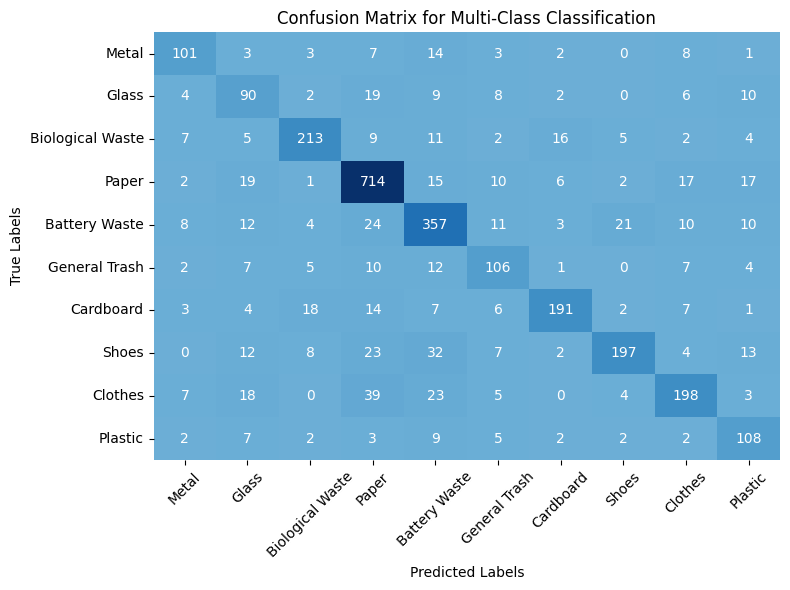

Confusion Matrix:
 [[101   3   3   7  14   3   2   0   8   1]
 [  4  90   2  19   9   8   2   0   6  10]
 [  7   5 213   9  11   2  16   5   2   4]
 [  2  19   1 714  15  10   6   2  17  17]
 [  8  12   4  24 357  11   3  21  10  10]
 [  2   7   5  10  12 106   1   0   7   4]
 [  3   4  18  14   7   6 191   2   7   1]
 [  0  12   8  23  32   7   2 197   4  13]
 [  7  18   0  39  23   5   0   4 198   3]
 [  2   7   2   3   9   5   2   2   2 108]]


In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# get the  confusion matrix
CM = confusion_matrix(y_true, y_pred)

# Define class labels to ensure accurate class names
class_names = ["Metal", "Glass", "Biological Waste", "Paper", "Battery Waste",
               "General Trash", "Cardboard", "Shoes", "Clothes", "Plastic"]
#set the figsize and plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(CM, fmt='g', annot=True, cmap='Blues', cbar=False, center=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print('Confusion Matrix:\n', CM)


model building resnet50

In [22]:
#Load the base model without the top layer
resnet_model_base = ResNet50(include_top=False, pooling='avg', weights='imagenet')

# Freeze the base model
resnet_model_base.trainable = False

# Add new layers
x = Dense(128, activation='relu')(resnet_model_base.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)  # Adjust output neurons as needed

#  the new model
model_2 = Model(inputs=resnet_model_base.input, outputs=output_layer)

#  model summary
model_2.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
early_stop=EarlyStopping(monitor='val_loss',patience=10)
cheackpoint=ModelCheckpoint(filepath='/colab/working/best.keras',monitor='val_loss',save_best_only=True,mode='auto')

In [24]:

model_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
history_2=model_2.fit(
           train_generator,
           steps_per_epoch=train_generator.samples//100,
           validation_data=valid_generator,
           validation_steps=valid_generator.samples//100,
           epochs=10,
           callbacks=[early_stop,cheackpoint]



)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 102s 610ms/step - accuracy: 0.7832 - loss: 0.6928 - val_accuracy: 0.9259 - val_loss: 0.2205
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9400 - loss: 0.1144 - val_accuracy: 0.9303 - val_loss: 0.2099
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 593ms/step - accuracy: 0.9493 - loss: 0.1589 - val_accuracy: 0.9386 - val_loss: 0.1695
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9500 - loss: 0.1633 - val_accuracy: 0.9397 - val_loss: 0.1655
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 74s 534ms/step - accuracy: 0.9696 - loss: 0.0931 - val_accuracy: 0.9459 - val_loss: 0.1634
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 1.0000 - loss: 0.0334 - val_accuracy: 0.9452 - val_loss: 0.1666
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 142s 626ms/step - accuracy: 0.9819 - loss: 0.0586 - val_accuracy: 0.9445 - val_loss: 0.1781
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9900 - loss: 0.0

Building CNN

In [26]:
# saving the model
model_2.save("my_model.keras")  # creates a .keras file

# HDF5 format
model_2.save("my_model_2.h5")     # creates a .h5 file


In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model_2.predict(test_generator, verbose=0)  # Predictions from the model

# np.argmax for multi class classification
y_pred_labels = np.argmax(y_pred, axis=1)

# get the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[133   1   2   0   1   4   1   0   0   0]
 [  0 148   0   0   1   0   0   0   0   1]
 [  2   0 240   0   0   4  24   3   0   1]
 [  0   0   0 801   0   0   1   0   1   0]
 [  0   0   0   0 429  15   1  10   2   3]
 [  0   0   0   2   8 141   2   0   0   1]
 [  0   1   3   0   0   2 245   1   0   1]
 [  0   1   1   1  16   5   3 265   1   5]
 [  0   0   0   4   2   1   0   1 288   1]
 [  1   0   1   5   1   0   9   3   2 120]]


In [28]:
from sklearn.metrics import classification_report
import numpy as np

# predicting the test dataset assuming the y pred as true vs the actual
y_pred_prob = model_2.predict(test_generator, verbose=0)

# For multiclass classification, convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

#  getting the generator classes and ensuring they are in the right format
y_true = test_generator.classes

# Generate classification report
ClassificationReport = classification_report(y_true, y_pred, target_names=["Metal", "Glass", "Biological Waste", "Paper",
                                                                          "Battery Waste", "General Trash", "Cardboard", "Shoes",
                                                                          "Clothes", "Plastic"])

# Print the classification report
print('Classification Report:\n', ClassificationReport)


Classification Report:
                   precision    recall  f1-score   support

           Metal       0.98      0.94      0.96       142
           Glass       0.98      0.99      0.98       150
Biological Waste       0.97      0.88      0.92       274
           Paper       0.99      1.00      0.99       803
   Battery Waste       0.94      0.93      0.93       460
   General Trash       0.82      0.92      0.87       154
       Cardboard       0.86      0.97      0.91       253
           Shoes       0.94      0.89      0.91       298
         Clothes       0.98      0.97      0.97       297
         Plastic       0.90      0.85      0.87       142

        accuracy                           0.95      2973
       macro avg       0.93      0.93      0.93      2973
    weighted avg       0.95      0.95      0.95      2973



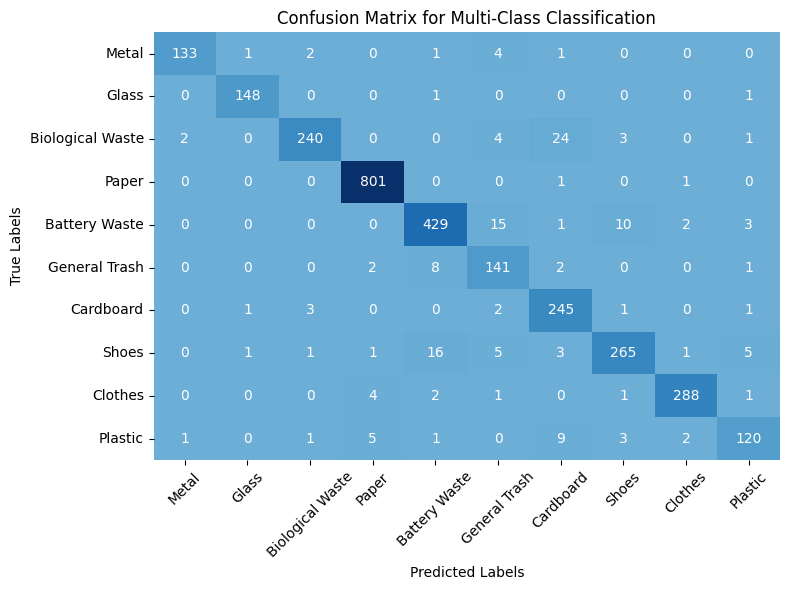

Confusion Matrix:
 [[133   1   2   0   1   4   1   0   0   0]
 [  0 148   0   0   1   0   0   0   0   1]
 [  2   0 240   0   0   4  24   3   0   1]
 [  0   0   0 801   0   0   1   0   1   0]
 [  0   0   0   0 429  15   1  10   2   3]
 [  0   0   0   2   8 141   2   0   0   1]
 [  0   1   3   0   0   2 245   1   0   1]
 [  0   1   1   1  16   5   3 265   1   5]
 [  0   0   0   4   2   1   0   1 288   1]
 [  1   0   1   5   1   0   9   3   2 120]]


In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# get the confusion matrix
CM = confusion_matrix(y_true, y_pred)

# the class labels across the ten categories my dataset
class_names = ["Metal", "Glass", "Biological Waste", "Paper", "Battery Waste",
               "General Trash", "Cardboard", "Shoes", "Clothes", "Plastic"]
#setting the figsize and plotting the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(CM, fmt='g', annot=True, cmap='Blues', cbar=False, center=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print('Confusion Matrix:\n', CM)


In [30]:
model_3=Sequential()

In [31]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2

# Define the input layer
input_layer = Input(shape=(224, 224, 3))

# First layer
x = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Second layer
x = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Third layer
x = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

# Output Layer (10 classes)
output_layer = Dense(10, activation='softmax')(x)

# Create the model
model_3 = Model(inputs=input_layer, outputs=output_layer)



In [32]:
# Compile the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [33]:
# Compile the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_3.summary()
history_3=model_3.fit(train_generator,epochs=15,validation_data=valid_generator,verbose=1,)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 97s 589ms/step - accuracy: 0.3664 - loss: 4.0676 - val_accuracy: 0.4263 - val_loss: 2.9450
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 488ms/step - accuracy: 0.4780 - loss: 2.5149 - val_accuracy: 0.4933 - val_loss: 2.1046
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 506ms/step - accuracy: 0.4984 - loss: 1.9628 - val_accuracy: 0.4862 - val_loss: 1.8788
Epoch 4/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 78s 560ms/step - accuracy: 0.5312 - loss: 1.7024 - val_accuracy: 0.4832 - val_loss: 1.7432
Epoch 5/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 486ms/step - accuracy: 0.5526 - loss: 1.5870 - val_accuracy: 0.5084 - val_loss: 1.6720
Epoch 6/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 489ms/step - accuracy: 0.5877 - loss: 1.4786 - val_accuracy: 0.5566 - val_loss: 1.5516
Epoch 7/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 487ms/step - accuracy: 0.6097 - loss: 1.3975 - val_accuracy: 0.5384 - val_loss: 1.5758
Epoch 8/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 75s 439ms/step - accuracy: 0.6316 - loss: 1

In [35]:
# saving the model
model_3.save("my_model.keras")  # creates a .keras file

# HDF5 format
model_3.save("my_model_3.h5")     # creates a .h5 file


In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model_3.predict(test_generator, verbose=0)

# np.argmax for multiclass classification.
y_pred_label = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_label)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 83   1  24   8   3   2  10   6   0   5]
 [  2  88  16  18   4   1   1   6   3  11]
 [  2   1 237  12   0   1   9   5   1   6]
 [  1   1  13 760   2   2   6  16   0   2]
 [ 27   3  41  24 218  29   4  86   4  24]
 [ 15   0  23  20   7  50  14  24   0   1]
 [  2   1  49  28   7  13 124  10   1  18]
 [  2   1  32  34  14  11   9 162   0  33]
 [ 59   2  26 110  11   2  11  12  51  13]
 [ 19   1   7   7   2   3   5  11   0  87]]


In [37]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_true is the true labels and y_pred are the predicted probabilities
y_pred_probability = model_3.predict(test_generator, verbose=0)

# np.argmax to connvert probablities in multi class classification.
y_pred = np.argmax(y_pred_probability, axis=1)

y_true = test_generator.classes

# Generate classification report
ClassificationReport = classification_report(y_true, y_pred, target_names=["Metal", "Glass", "Biological Waste", "Paper",
                                                                          "Battery Waste", "General Trash", "Cardboard", "Shoes",
                                                                          "Clothes", "Plastic"])

# Print the classification report
print('Classification Report:\n', ClassificationReport)


Classification Report:
                   precision    recall  f1-score   support

           Metal       0.39      0.58      0.47       142
           Glass       0.89      0.59      0.71       150
Biological Waste       0.51      0.86      0.64       274
           Paper       0.74      0.95      0.83       803
   Battery Waste       0.81      0.47      0.60       460
   General Trash       0.44      0.32      0.37       154
       Cardboard       0.64      0.49      0.56       253
           Shoes       0.48      0.54      0.51       298
         Clothes       0.85      0.17      0.29       297
         Plastic       0.43      0.61      0.51       142

        accuracy                           0.63      2973
       macro avg       0.62      0.56      0.55      2973
    weighted avg       0.67      0.63      0.61      2973



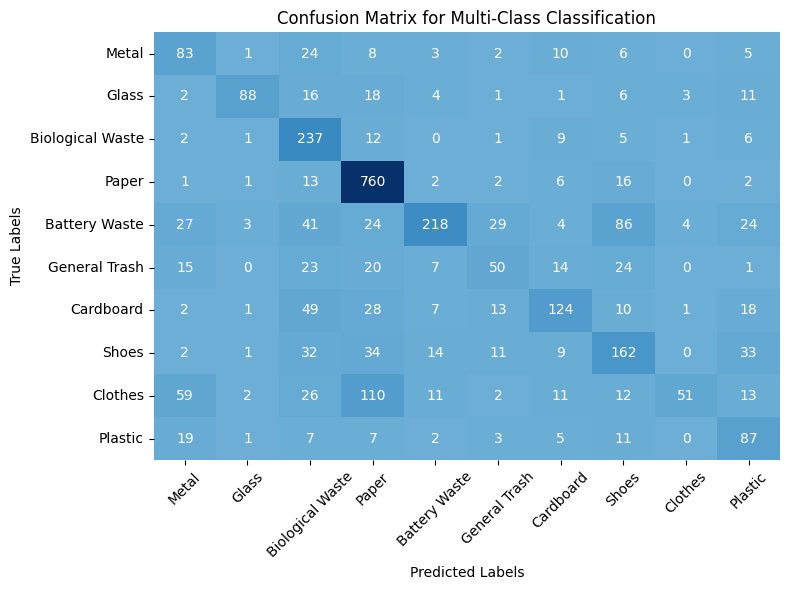

Confusion Matrix:
 [[ 83   1  24   8   3   2  10   6   0   5]
 [  2  88  16  18   4   1   1   6   3  11]
 [  2   1 237  12   0   1   9   5   1   6]
 [  1   1  13 760   2   2   6  16   0   2]
 [ 27   3  41  24 218  29   4  86   4  24]
 [ 15   0  23  20   7  50  14  24   0   1]
 [  2   1  49  28   7  13 124  10   1  18]
 [  2   1  32  34  14  11   9 162   0  33]
 [ 59   2  26 110  11   2  11  12  51  13]
 [ 19   1   7   7   2   3   5  11   0  87]]


In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# get the  confusion matrix
CM = confusion_matrix(y_true, y_pred)

# class names of our classes across ten categories
class_names = ["Metal", "Glass", "Biological Waste", "Paper", "Battery Waste",
               "General Trash", "Cardboard", "Shoes", "Clothes", "Plastic"]
#plotting the confusion matrix values
plt.figure(figsize=(8, 6))
sns.heatmap(CM, fmt='g', annot=True, cmap='Blues', cbar=False, center=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print('Confusion Matrix:\n', CM)


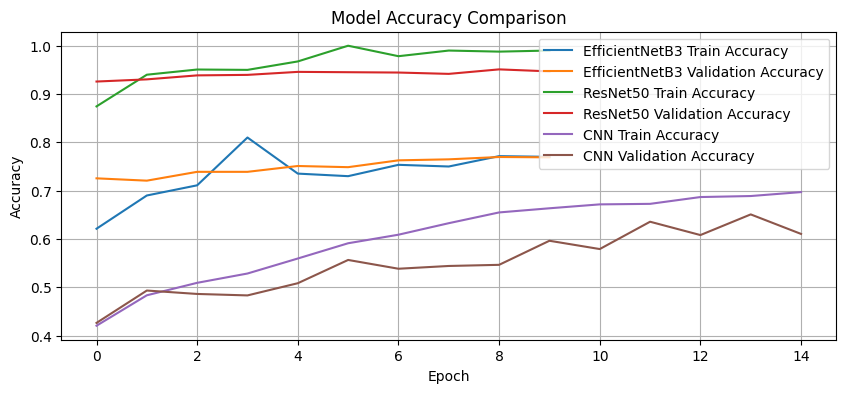

In [39]:
plt.figure(figsize=(10, 4))



#   EfficientNetB3
plt.plot(history_1.history['accuracy'], label='EfficientNetB3 Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='EfficientNetB3 Validation Accuracy')

# ResNet50
plt.plot(history_2.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='ResNet50 Validation Accuracy')

# Convolution
plt.plot(history_3.history['accuracy'], label='CNN Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='CNN Validation Accuracy')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


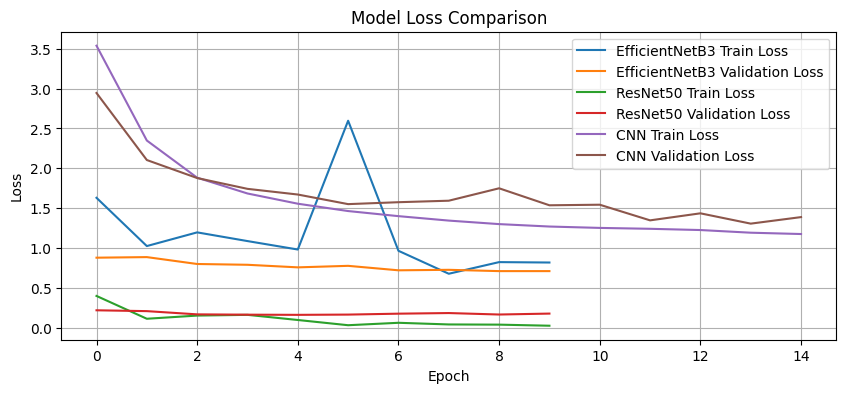

In [40]:
plt.figure(figsize=(10, 4))

# EfficientNetB3
plt.plot(history_1.history['loss'], label='EfficientNetB3 Train Loss')
plt.plot(history_1.history['val_loss'], label='EfficientNetB3 Validation Loss')


# ResNet50
plt.plot(history_2.history['loss'], label='ResNet50 Train Loss')
plt.plot(history_2.history['val_loss'], label='ResNet50 Validation Loss')

# Convolution
plt.plot(history_3.history['loss'], label='CNN Train Loss')
plt.plot(history_3.history['val_loss'], label='CNN Validation Loss')

plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [43]:
# Evaluate model_1 (e.g., EfficientNetB0) on the test data
test_loss_1, test_accuracy_1 = model_1.evaluate(test_generator)
print(f"Test Accuracy for EfficientNetB0: {test_accuracy_1:.4f}")

# Evaluate model_2 (e.g., ResNet50) on the test data
test_loss_2, test_accuracy_2 = model_2.evaluate(test_generator)
print(f"Test Accuracy for ResNet50: {test_accuracy_2:.4f}")

# If you have a third model, model_3 (e.g., custom CNN)
test_loss_3, test_accuracy_3 = model_3.evaluate(test_generator)
print(f"Test Accuracy for Custom CNN: {test_accuracy_3:.4f}")


2973/2973 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.7713 - loss: 0.7116
Test Accuracy for EfficientNetB0: 0.7652
2973/2973 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9483 - loss: 0.1624
Test Accuracy for ResNet50: 0.9452
2973/2973 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7236 - loss: 1.1903
Test Accuracy for Custom CNN: 0.6256


Predictions EfficientNB

In [ ]:
prediction=model_1.predict(test_generator,steps=len(test_generator),verbose=1)
predict_classes_11=np.argmax(prediction,axis=1)

2973/2973 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step


In [45]:
class_labels=list(train_generator.class_indices.keys())
class_labels

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

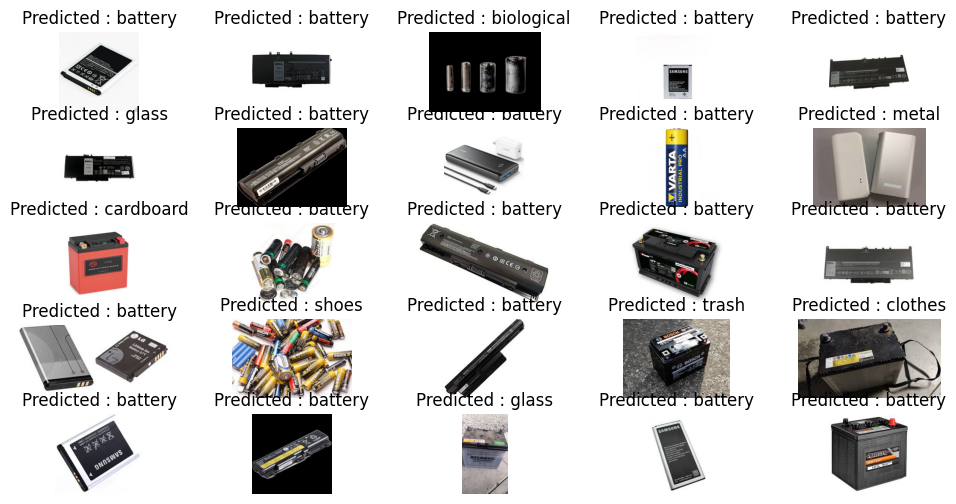

In [ ]:
fig,ax=plt.subplots(5,5,figsize=(12,6))
for i in range(25):  # Loop through first 25 images
    image_path = os.path.join(test_dir, test_generator.filenames[i])  # Correct full path
    image = load_image(image_paths)  # Load image

    predict_class = class_labels[predict_classes_11[i]]

    ax[i//5 , i%5].imshow(image)
    ax[i//5 , i%5].axis('off')
    ax[i//5 , i%5].set_title(f"Predicted : {predict_class}")

Prediction Resnet50

In [ ]:
prediction=model_2.predict(test_generator,steps=len(test_generator),verbose=1)
predict_classes=np.argmax(prediction,axis=1)

2973/2973 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step


In [48]:
class_labels=list(train_generator.class_indices.keys())
class_labels

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

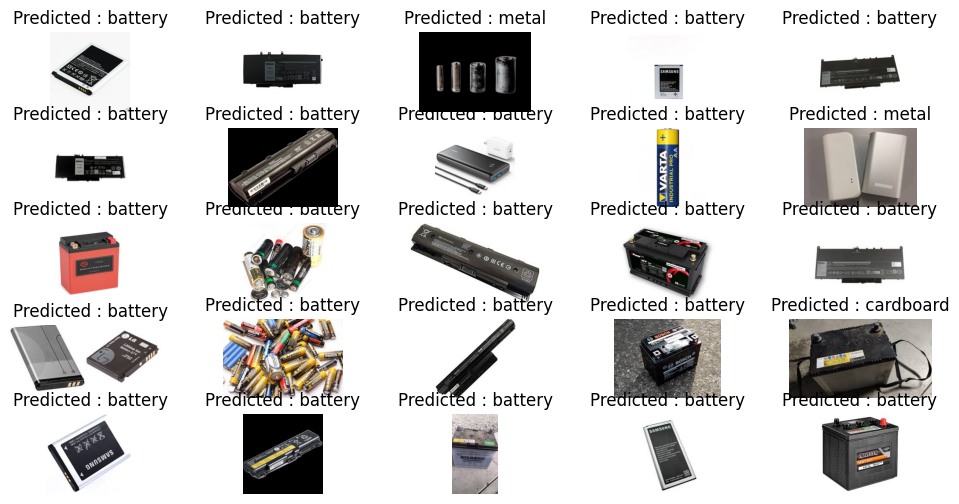

In [ ]:
fig,ax=plt.subplots(5,5,figsize=(12,6))
for i in range(25):  # Loop through first 25 images
    image_paths = os.path.join(test_dir, test_generator.filenames[i])  # Correct full path
    image = load_image(image_paths)  # Load image

    predict_class = class_labels[predict_classes[i]]

    ax[i//5 , i%5].imshow(image)
    ax[i//5 , i%5].axis('off')
    ax[i//5 , i%5].set_title(f"Predicted : {predict_class}")

Prediction CNN

In [ ]:
pred=model_3.predict(test_generator,steps=len(test_generator),verbose=1)
predict_classes_3=np.argmax(pred,axis=1)

2973/2973 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


In [51]:
class_labels=list(train_generator.class_indices.keys())
class_labels

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

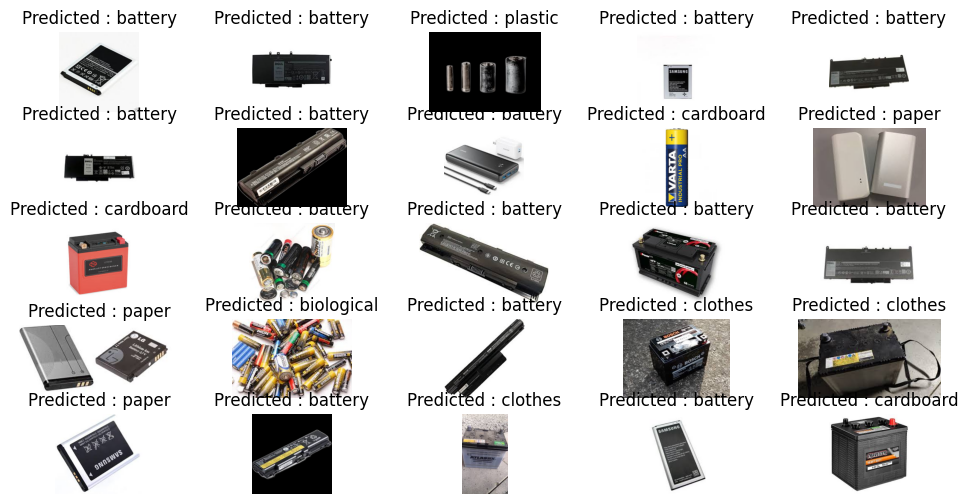

In [ ]:
fig,ax=plt.subplots(5,5,figsize=(12,6))
for i in range(25):  # Loop through first 25 images
    image_paths = os.path.join(test_dir, test_generator.filenames[i])  # Correct full path
    image = load_image(image_paths)  # Load image

    predict_class = class_labels[predict_classes_3[i]]

    ax[i//5 , i%5].imshow(image)
    ax[i//5 , i%5].axis('off')
    ax[i//5 , i%5].set_title(f"Predicted : {predict_class}")